# Model One
### Logistic Regression, Random Forest, Extra Trees Classifier

This Notbook should predict whether a certain path in a model should be animated or not based on the embedding and additional features created.

For training we are using self-labeled data.

In [2]:
import os
os.chdir("..")

In [3]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pprint import pprint

C:\Users\sarah\Anaconda3\lib\site-packages\scipy\__init__.py:137: UserWarning: NumPy 1.16.5 or above is required for this version of SciPy (detected version 1.16.1)
  UserWarning)


### 1. Load and map data

Delete rows of logo_id (provided through filename) and order_id (not important)

In [4]:
target = pd.read_csv("data/model_1/model_1_path_label.csv")
target["logo"] = target["logo_id"].apply(lambda row: "logo_" + str(row)) # set up logo numeration for labeling
target = target.drop(['logo_id','order_id','filename'], axis = 1) # drop unnecessary attributes
target['animation_id'] = target['animation_id'].astype(int) #transform animation_id to int for mapping with feature table
target=target.rename(columns={"logo": "filename"}) # transform for feature mapping
target.head()

,animation_id,animate,filename
0,5,0.578947,logo_0
1,0,0.526316,logo_0
2,2,0.526316,logo_0
3,4,0.684211,logo_0
4,3,0.526316,logo_0


Load an match of training data

In [5]:
X_train = pd.read_csv("data/model_1/model_1_train.csv")
X_train = X_train.drop("Unnamed: 0", axis=1) # Delete unneccessary columnd which was copied as indice
X_train.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
0,logo_0,1,11.268934,10.784905,-1.795118,-1.315936,0.699395,4.745064,2.583316,0.997763,...,0.0,0.0,0.0,0.0,0.0,0.391017,0.458231,0.706957,0.577049,10
1,logo_0,0,-4.928805,1.693890,2.650219,0.417880,2.906058,5.822047,1.973111,-0.043525,...,0.0,0.0,0.0,0.0,0.0,0.488551,0.651937,0.267174,0.355178,10
2,logo_0,3,8.363034,-0.790123,4.012104,0.711058,-2.457028,3.136327,2.176535,0.519116,...,0.0,0.0,0.0,0.0,0.0,0.391042,0.458231,0.315928,0.577049,10
3,logo_0,2,11.966211,2.788607,3.678947,0.402484,-2.509481,0.135113,1.815825,5.770873,...,0.0,0.0,0.0,0.0,0.0,0.769168,0.318733,0.511441,0.840633,10
4,logo_0,5,8.457268,14.647492,2.389777,-1.438775,-3.225150,0.856066,1.528019,1.883333,...,0.0,0.0,0.0,0.0,0.0,0.488551,0.651931,0.755725,0.355181,10


Merge Darframe based on the paths for which we have an annotation (df)

In [6]:
new_df = pd.merge(target, X_train,  how='left', left_on=['filename','animation_id'], right_on=['filename','animation_id'])
new_df.head(5)

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
0,5,0.578947,logo_0,8.457268,14.647492,2.389777,-1.438775,-3.225150,0.856066,1.528019,...,0.0,0.0,0.0,0.0,0.0,0.488551,0.651931,0.755725,0.355181,10.0
1,0,0.526316,logo_0,-4.928805,1.693890,2.650219,0.417880,2.906058,5.822047,1.973111,...,0.0,0.0,0.0,0.0,0.0,0.488551,0.651937,0.267174,0.355178,10.0
2,2,0.526316,logo_0,11.966211,2.788607,3.678947,0.402484,-2.509481,0.135113,1.815825,...,0.0,0.0,0.0,0.0,0.0,0.769168,0.318733,0.511441,0.840633,10.0
3,4,0.684211,logo_0,1.638388,1.885517,1.183481,0.626105,-1.238035,5.465185,3.710409,...,0.0,0.0,0.0,0.0,0.0,0.573461,0.306260,0.511553,0.194615,10.0
4,3,0.526316,logo_0,8.363034,-0.790123,4.012104,0.711058,-2.457028,3.136327,2.176535,...,0.0,0.0,0.0,0.0,0.0,0.391042,0.458231,0.315928,0.577049,10.0


Delete rows in which we have NaN embeddings

In [7]:
new_df = new_df.dropna(axis=0,thresh=4)

Load Test data set and drop same features

In [8]:
X_test = pd.read_csv("data/model_1/model_1_test.csv")
X_test = X_test.drop("Unnamed: 0",axis=1)
X_test.head()

,filename,animation_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
0,logo_147,1,-2.418838,-6.150059,-4.100762,3.168622,-2.697222,0.687456,0.082696,-0.084968,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.025447,0.357524,0.177258,0.461866,13
1,logo_147,0,-7.542565,-6.009832,-0.636685,2.111591,0.388539,-0.564557,2.733660,-1.164462,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.074259,0.540364,0.060423,0.547507,13
2,logo_147,10,6.748562,-5.192357,0.649270,-4.662319,-0.271619,-0.581692,-0.186817,1.081577,...,141.538462,22.076923,134.923077,34.769231,121.230769,0.017044,0.085221,0.183468,0.182756,13
3,logo_147,12,0.790715,0.447205,-3.142827,-2.614898,-0.818243,0.950761,-1.274994,-1.938930,...,6.538462,22.076923,42.923077,34.769231,113.230769,0.055225,0.207291,0.502015,0.221658,13
4,logo_147,2,-0.550477,-2.664404,-7.260686,4.091919,-1.184668,1.764147,0.267756,0.149615,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.047815,0.364758,0.131559,0.458241,13


In [9]:
test_df = pd.merge(target, X_test,  how='left', left_on=['filename','animation_id'], right_on=['filename','animation_id'])
test_df = test_df.dropna(axis=0, thresh=4)
test_df.head()

,animation_id,animate,filename,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,diff_stroke_r,svg_stroke_g,diff_stroke_g,svg_stroke_b,diff_stroke_b,rel_width,rel_height,rel_x_position,rel_y_position,nr_paths_svg
1150,11,1.0,logo_147,3.236627,0.373583,-7.378661,5.802886,0.187992,1.863424,-1.648710,...,6.538462,22.076923,42.923077,34.769231,113.230769,0.172791,0.610861,0.418358,0.576557,13.0
1151,3,0.0,logo_147,6.555051,-11.237650,-1.761144,9.656722,2.110759,2.052200,1.549353,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.113487,0.364979,0.259243,0.458139,13.0
1152,5,0.0,logo_147,15.187959,0.953012,-4.555714,0.081866,0.626855,-1.532500,2.397167,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.074262,0.540355,0.832217,0.547495,13.0
1153,4,0.0,logo_147,3.777620,-1.415217,-5.265458,0.380917,-1.089346,-0.729920,2.860979,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.074263,0.540364,0.595574,0.547499,13.0
1154,0,0.0,logo_147,-7.542565,-6.009832,-0.636685,2.111591,0.388539,-0.564557,2.733660,...,-15.461538,22.076923,-22.076923,34.769231,-34.769231,0.074259,0.540364,0.060423,0.547507,13.0


### 2. Feature Selection

We want to take a look on the correlation matrix to identify features which can be excluded upfront.

C:\Users\sarah\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


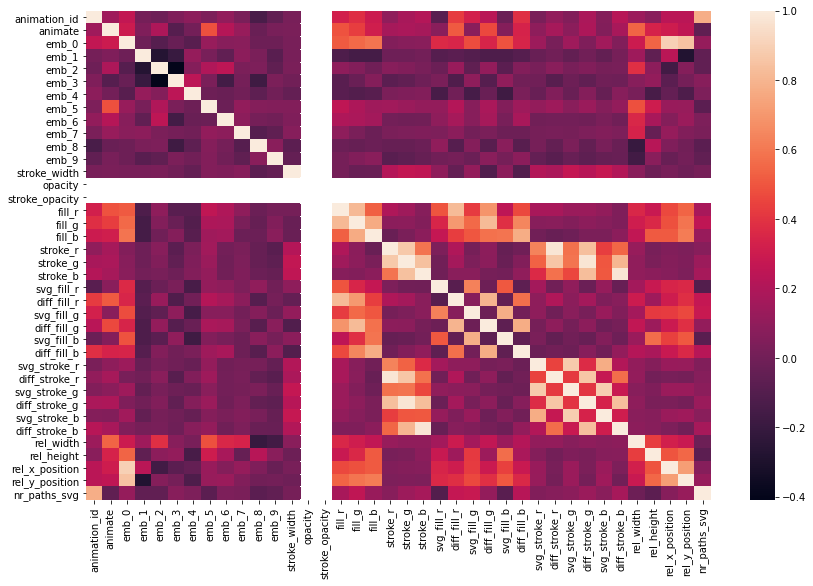

In [10]:
corrMatrix = new_df.corr()
f = plt.figure(figsize=(14, 9))
sn.heatmap(corrMatrix, annot=False)
f.show()

Since both _opacity_ and _stroke_opacity_ are always of value *one* we exclude them.

In [11]:
new_df = new_df.drop(['opacity','stroke_opacity'], axis=1, errors='ignore')
test_df = test_df.drop(['opacity','stroke_opacity'], axis= 1, errors='ignore')

Also exclude stroke attributes because they are mostly not given.

In [12]:
new_df = new_df.drop(['stroke_r','stroke_g', 'stroke_b', 'stroke_width'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_r', 'diff_stroke_r'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_g', 'diff_stroke_g'], axis= 1, errors='ignore')
new_df = new_df.drop(['svg_stroke_b', 'diff_stroke_b'], axis= 1, errors='ignore')

test_df = test_df.drop(['stroke_r','stroke_g', 'stroke_b', 'stroke_width'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_r', 'diff_stroke_r'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_g', 'diff_stroke_g'], axis= 1, errors='ignore')
test_df = test_df.drop(['svg_stroke_b', 'diff_stroke_b'], axis= 1, errors='ignore')

Check for features that have a to high correlation.

In [13]:
correlated_features = set()
correlation_matrix = new_df.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"The following features are correlated: {correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}. Correlation = {round(abs(correlation_matrix.iloc[i, j]),2)}")
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(f"Drop the following features: {correlated_features}")
#corr_features = list(correlated_features)
#test_df = test_df.drop(corr_features, axis=1, errors='ignore')
#new_df = new_df.drop(corr_features, axis=1, errors='ignore')

The following features are correlated: fill_g and fill_r. Correlation = 0.81
The following features are correlated: diff_fill_r and fill_r. Correlation = 0.82
The following features are correlated: diff_fill_g and fill_g. Correlation = 0.82
The following features are correlated: rel_x_position and emb_0. Correlation = 0.9
The following features are correlated: rel_y_position and emb_0. Correlation = 0.85
Drop the following features: {'rel_x_position', 'fill_g', 'diff_fill_r', 'diff_fill_g', 'rel_y_position'}


Animation ID is only an identifier and is excluded later. Only drop rel_x_position for logistic regression (is done later). Decision Trees are not affected by multicollinearity in features.

### 3. Preprocessing

Add function that replaces animate decision with binary integrer values

In [14]:
new_df['animate']=[0 if x < 0.5 else 1 for x in new_df['animate']]
test_df['animate']=[0 if x < 0.5 else 1 for x in test_df['animate']]

#### Perform split between features and target

In [15]:
x_train = new_df.drop(['filename','animation_id','animate'], axis=1, errors='ignore')
y_train = new_df['animate']
x_test = test_df.drop(['filename','animation_id','animate'], axis=1, errors='ignore')
y_test = test_df['animate']

### 4. Implement models

#### 4.1 Random Forest

#### Randomized search on hyperparameters

In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 240, 460, 680, 900, 1120, 1340, 1560, 1780, 2000]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=240; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=240; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=240; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.9s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  10.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   9.5s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1120;

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 240, 460, 680, 900,
                                                         1120, 1340, 1560, 1780,
                                                         2000]},
                   random_state=42, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 240,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': True}

In [38]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
y_pred = base_model.predict(x_test)
print(f'Accuracy of random forest classifier on test set without hyperparameter optimization: {base_model.score(x_test, y_test)}')

Accuracy of random forest classifier on test set without hyperparameter optimization: 0.9290882778581766


In [38]:
best_random = rf_random.best_estimator_
best_random.fit(x_train, y_train)
y_pred = best_random.predict(x_test)
print(f'Accuracy of random forest classifier on test set with hyperparameter optimization: {best_random.score(x_test, y_test)}')

Accuracy of random forest classifier with 261 estimators on test set: 0.9189944134078212


In [39]:
# save model
filename = 'models/model_1_random_forest.sav'
pickle.dump(best_random, open(filename, 'wb'))

In [40]:
# load model
#loaded_model = pickle.load(open('models/model_1_random_forest.sav', 'rb'))
#y_pred = loaded_model.predict(x_test)
#result = loaded_model.score(x_test, y_test)
#print(result)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       267
           1       0.87      0.80      0.83        91

    accuracy                           0.92       358
   macro avg       0.90      0.88      0.89       358
weighted avg       0.92      0.92      0.92       358



#### 4.2 Extra Trees Classifier

In [16]:
et = ExtraTreesClassifier(random_state=17)
et.fit(x_train, y_train)

ExtraTreesClassifier(random_state=17)

In [17]:
# 0.94
y_pred = et.predict(x_test)
print('Accuracy of extra trees classifier on test set: {:.2f}'.format(et.score(x_test, y_test)))

Accuracy of extra trees classifier on test set: 0.95


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       525
           1       0.89      0.90      0.89       166

    accuracy                           0.95       691
   macro avg       0.93      0.93      0.93       691
weighted avg       0.95      0.95      0.95       691



Feature ranking:
1. feature 19: rel_width (9.17%)
2. feature 10: fill_r (8.54%)
3. feature 5: emb_5 (7.42%)
4. feature 14: diff_fill_r (6.99%)
5. feature 22: rel_y_position (6.7%)
6. feature 16: diff_fill_g (6.39%)
7. feature 11: fill_g (5.43%)
8. feature 21: rel_x_position (4.94%)
9. feature 12: fill_b (4.37%)
10. feature 18: diff_fill_b (4.2%)
11. feature 13: svg_fill_r (3.9%)
12. feature 20: rel_height (3.8%)
13. feature 17: svg_fill_b (3.73%)
14. feature 23: nr_paths_svg (3.62%)
15. feature 15: svg_fill_g (3.61%)
16. feature 0: emb_0 (2.78%)
17. feature 8: emb_8 (2.41%)
18. feature 2: emb_2 (2.31%)
19. feature 3: emb_3 (2.08%)
20. feature 6: emb_6 (1.76%)
21. feature 1: emb_1 (1.58%)
22. feature 7: emb_7 (1.57%)
23. feature 4: emb_4 (1.47%)
24. feature 9: emb_9 (1.22%)


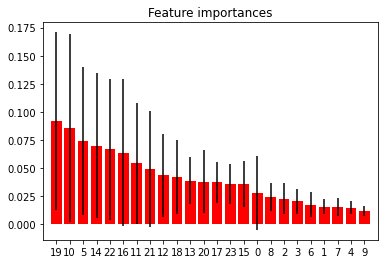

In [19]:
importances = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print(f"{f+1}. feature {indices[f]}: {x_train.columns[indices[f]]} ({round(importances[indices[f]]*100,2)}%)")

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

#### 4.3 XGBoost

In [41]:
# 0.93
xgb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print('Accuracy of XGBoost on test set: {:.2f}'.format(xgb.score(x_test, y_test)))

Accuracy of XGBoost on test set: 0.93


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       525
           1       0.89      0.80      0.84       166

    accuracy                           0.93       691
   macro avg       0.91      0.88      0.90       691
weighted avg       0.93      0.93      0.93       691



#### 4.4 Logistic Regression

Features which are correlated to strong are ignored

In [21]:
x_train_lr = x_train.drop(['rel_x_position'], axis=1, errors='ignore')
x_test_lr = x_test.drop(['rel_x_position'], axis= 1, errors='ignore')

Now we perform the actual regression

In [23]:
logreg = LogisticRegression(solver='lbfgs', max_iter=200000)
logreg.fit(x_train_lr, y_train)

LogisticRegression(max_iter=200000)

In [25]:
# 0.86
y_pred = logreg.predict(x_test_lr)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test_lr, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


In [ ]:
print(classification_report(y_test, y_pred))

### Result

Extra Trees Classifier performed best

In [20]:
# save model
filename = 'models/model_1_extra_trees_classifier.sav'
pickle.dump(et, open(filename, 'wb'))

In [23]:
# load model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.9479015918958031
